## IMPORTING REQUIRED PACKAGES

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.transforms as transforms

## DEFINING OUR MLP AND CNN NETWORKS

In [ ]:
#defining our multi-layer perceptron with two fully connected layers with 512 nodes
class mlp_nn(nn.Module):
    def __init__(self, inp_dim, h_nodes=512):
        super(mlp_nn, self).__init__()
        self.fc1 = nn.Linear(inp_dim, h_nodes)
        self.fc2 = nn.Linear(h_nodes, h_nodes)
        self.fc3 = nn.Linear(h_nodes, 10)
        self.inp_dim = inp_dim

    def forward(self, x):
        x = x.view(-1, self.inp_dim)
        x = torch.sigmoid(self.fc1(x)) #using sigmoid activation function
        x = torch.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x

#defining our multi-layer perceptron with two fully connected layers with 1024 and 512 nodes
class mlp_nn2(nn.Module):
    def __init__(self, inp_dim, h_nodes=None):
        super(mlp_nn2, self).__init__()
        if h_nodes is None:
            h_nodes = [1024, 512]
        self.fc1 = nn.Linear(inp_dim, h_nodes[0])
        self.fc2 = nn.Linear(h_nodes[0], h_nodes[1])
        self.fc3 = nn.Linear(h_nodes[1], 10)
        self.inp_dim = inp_dim

    def forward(self, x):
        x = x.view(-1, self.inp_dim)
        x = torch.sigmoid(self.fc1(x)) #using sigmoid activation function
        x = torch.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x


#defining our multi-layer perceptron with three fully connected layers with 1024,512 and 512 nodes respectively
class mlp_nn3(nn.Module):
    def __init__(self, inp_dim, h_nodes=None):
        super(mlp_nn3, self).__init__()
        if h_nodes is None:
            h_nodes = [1024, 512, 512]
        self.fc1 = nn.Linear(inp_dim, h_nodes[0])
        self.fc2 = nn.Linear(h_nodes[0], h_nodes[1])
        self.fc3 = nn.Linear(h_nodes[1], h_nodes[2])
        self.fc4 = nn.Linear(h_nodes[2], 10)
        self.inp_dim = inp_dim

    def forward(self, x):
        x = x.view(-1, self.inp_dim)
        x = torch.sigmoid(self.fc1(x)) #using sigmoid activation function
        x = torch.sigmoid(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        x = self.fc4(x)
        return x

#defining our first convolutional neural network with conv layers of 64 filters and two dense layers with 512 nodes
class CNN1(nn.Module):
    def __init__(self):
        super(CNN1, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, 1, 1)
        self.conv2 = nn.Conv2d(64, 64, 3, 1, 1)
        self.fc1 = nn.Linear(64*32*32, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x)) #using ReLU activation function for the conv layers
        x = F.relu(self.conv2(x))
        x = x.view(-1, 64*32*32)
        x = torch.sigmoid(self.fc1(x)) #using sigmoid activation function for the dense layers
        x = torch.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x

#defining our second convolutional neural network with conv layers of 64 filters and two dense layers with 512 nodes
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, 1, 1)
        self.conv2 = nn.Conv2d(64, 64, 3, 1, 1)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2)) #using ReLU activation function for the conv layers
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = x.view(-1, 64*8*8)
        x = torch.sigmoid(self.fc1(x)) #using sigmoid activation function for the dense layers
        x = F.dropout(x, 0.2)          #assigning a drop out rate of 0.2
        x = torch.sigmoid(self.fc2(x))
        x = F.dropout(x, 0.2)
        x = self.fc3(x)
        return x

## DEFINING FUNCTIONS FOR TRAINING AND PREDICTING USING OUR MODELS

In [ ]:
#defining fucntion to train our model and running it for 5 epochs
def train(model, optimizer, loss_func, traindata_loader, valdata_loader=None, epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #device function used to specify CPU or GPU
    model = model.to(device)
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    for epoch in range(1, epochs+1):
        model.train()
        train_loss = 0
        correct = 0
        for batch_idx, (data, target) in enumerate(traindata_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            loss = loss_func(output, target) #calculating the loss for our train model
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_losses.append(train_loss)                             
        accuracy = correct / len(traindata_loader.dataset) #calculating accuracy for our train model
        train_accuracies.append(accuracy)
        print('Train Epoch: %i, Train Loss: %f, Train Accuracy: %f' % (epoch, train_loss, accuracy))
        if valdata_loader is not None:
            model.eval()
            val_loss = 0
            correct = 0
            with torch.no_grad():
                for batch_idx, (data, target) in enumerate(valdata_loader):
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    pred = output.max(1, keepdim=True)[1]
                    correct += pred.eq(target.view_as(pred)).sum().item()
                    loss = loss_func(output, target) #calculating the loss for our val model
                    val_loss += loss.item()
            val_losses.append(val_loss)
            accuracy = correct / len(valdata_loader.dataset) #calculating accuracy for our val model
            val_accuracies.append(accuracy)
            print('Val Epoch:   %i, Val Loss: %f, Val Accuracy: %f' % (epoch, val_loss, accuracy))
    return train_losses, train_accuracies, val_losses, val_accuracies

#defining predict function for predicting on our test data
def predict(model, loss_func, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #device function used to specify CPU or GPU        
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            loss = loss_func(output, target) #calculating the loss for our test data model
            test_loss += loss.item()
    accuracy = correct / len(test_loader.dataset) #calculating accuracy for our test data model
    print('Test Loss: %f, Test Accuracy: %f' % (test_loss, accuracy))

## GENERATING OUR FINAL DATASET

In [ ]:
#loading the CIFAR10 dataset for our training and test dataset
train_set = datasets.CIFAR10(root='./data/', train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), 
                                                                                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
test_set_ = datasets.CIFAR10(root='./data/', train=False, download=True, transform=transforms.Compose([transforms.ToTensor(), 
                                                                                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
n_train = len(train_set)
batch_size = 32
split = n_train // 5 #taking 20% (1/5) of our original training data
indices = np.random.permutation(n_train)
subset_sampler = torch.utils.data.sampler.SubsetRandomSampler(indices[:split]) #randomly sampling the 20% of our original training data 
traindata_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=subset_sampler) #storing our new training data as traindata_loader
n_test = len(test_set_)
val_set, test_set = torch.utils.data.random_split(test_set_, [n_test//2, n_test//2]) #splitting original test data into validation and new test dataset
valdata_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data/
Files already downloaded and verified


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #device function used to specify CPU or GPU 
inp_dim = train_set.data[0].reshape((-1, 1)).shape[0]

## RUNNING OUR DIFFERENT MLP MODELS

In [ ]:
#calling our first MLP model with two layers of 512 nodes [512,512]
model = mlp_nn(inp_dim, 512)

learning_rate = 1e-4 #setting the learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #using the adam optimizer             
loss_func = nn.CrossEntropyLoss() #using cross entropy loss as our loss function

#training the model and returning training, validation loss and accuracies for each epoch
train_losses_512, train_accuracies_512, val_losses_512, val_accuracies_512 = train(model, optimizer, loss_func, traindata_loader, valdata_loader, 5)  

#calling the predict function to return the model's test loss and accuracy
predict(model, loss_func, test_loader)

Train Epoch: 1, Train Loss: 655.187195, Train Accuracy: 0.049240
Val Epoch:   1, Val Loss: 308.016603, Val Accuracy: 0.296400
Train Epoch: 2, Train Loss: 594.337903, Train Accuracy: 0.065120
Val Epoch:   2, Val Loss: 294.685175, Val Accuracy: 0.338800
Train Epoch: 3, Train Loss: 569.767211, Train Accuracy: 0.072380
Val Epoch:   3, Val Loss: 285.489869, Val Accuracy: 0.358600
Train Epoch: 4, Train Loss: 553.798307, Train Accuracy: 0.075960
Val Epoch:   4, Val Loss: 279.939363, Val Accuracy: 0.366000
Train Epoch: 5, Train Loss: 541.047614, Train Accuracy: 0.079000
Val Epoch:   5, Val Loss: 275.676880, Val Accuracy: 0.380200
Test Loss: 273.750356, Test Accuracy: 0.383000


In [ ]:
#calling our second MLP model with two layers of 1024 nodes and 512 nodes respectively[1024,512]
model = mlp_nn(inp_dim, 1024)
learning_rate = 1e-4 #setting the learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #using the adam optimizer 
loss_func = nn.CrossEntropyLoss()  #using cross entropy loss as our loss function

#training the model and returning training, validation loss and accuracies for each epoch                                             
train_losses_1024, train_accuracies_1024, val_losses_1024, val_accuracies_1024 = train(model, optimizer, loss_func, traindata_loader, valdata_loader, 5)

#calling the predict function to return the model's test loss and accuracy
predict(model, loss_func, test_loader)

Train Epoch: 1, Train Loss: 638.253250, Train Accuracy: 0.050760
Val Epoch:   1, Val Loss: 300.140049, Val Accuracy: 0.298800
Train Epoch: 2, Train Loss: 578.578336, Train Accuracy: 0.070460
Val Epoch:   2, Val Loss: 286.361375, Val Accuracy: 0.356400
Train Epoch: 3, Train Loss: 556.421720, Train Accuracy: 0.074000
Val Epoch:   3, Val Loss: 281.391019, Val Accuracy: 0.364400
Train Epoch: 4, Train Loss: 541.917225, Train Accuracy: 0.078620
Val Epoch:   4, Val Loss: 274.790827, Val Accuracy: 0.379200
Train Epoch: 5, Train Loss: 528.923713, Train Accuracy: 0.081920
Val Epoch:   5, Val Loss: 273.450282, Val Accuracy: 0.392000
Test Loss: 270.626002, Test Accuracy: 0.390600


In [ ]:
#calling our third MLP model with two layers of 1024 nodes [1024,1024]
model = mlp_nn2(inp_dim=inp_dim)
learning_rate = 1e-4 #setting the learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  #using the adam optimizer              
loss_func = nn.CrossEntropyLoss() #using cross entropy loss as our loss function    

#training the model and returning training, validation loss and accuracies for each epoch 
train_losses_1024_2, train_accuracies_1024_2, val_losses_1024_2, val_accuracies_1024_2 = train(model, optimizer, loss_func, traindata_loader, valdata_loader, 5)

#calling the predict function to return the model's test loss and accuracy
predict(model, loss_func, test_loader)

Train Epoch: 1, Train Loss: 642.696610, Train Accuracy: 0.051600
Val Epoch:   1, Val Loss: 302.146559, Val Accuracy: 0.311000
Train Epoch: 2, Train Loss: 583.057743, Train Accuracy: 0.069480
Val Epoch:   2, Val Loss: 288.822357, Val Accuracy: 0.357800
Train Epoch: 3, Train Loss: 559.515563, Train Accuracy: 0.074120
Val Epoch:   3, Val Loss: 281.489325, Val Accuracy: 0.365600
Train Epoch: 4, Train Loss: 543.495817, Train Accuracy: 0.078700
Val Epoch:   4, Val Loss: 275.307576, Val Accuracy: 0.384400
Train Epoch: 5, Train Loss: 530.976310, Train Accuracy: 0.081360
Val Epoch:   5, Val Loss: 272.429591, Val Accuracy: 0.384200
Test Loss: 270.636827, Test Accuracy: 0.393600


In [ ]:
#calling our final MLP model with three layers of 1024,512 and 512 nodes [1024,512,512]
model = mlp_nn3(inp_dim=inp_dim)
learning_rate = 1e-4 #setting the learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #using the adam optimizer 
loss_func = nn.CrossEntropyLoss()  #using cross entropy loss as our loss function 

#training the model and returning training, validation loss and accuracies for each epoch 
train_losses_512_2, train_accuracies_512_2, val_losses_512_2, val_accuracies_512_2 = train(model, optimizer, loss_func, traindata_loader, valdata_loader, 5)

#calling the predict function to return the model's test loss and accuracy
predict(model, loss_func, test_loader)

Train Epoch: 1, Train Loss: 669.887305, Train Accuracy: 0.038420
Val Epoch:   1, Val Loss: 315.593537, Val Accuracy: 0.244800
Train Epoch: 2, Train Loss: 609.106185, Train Accuracy: 0.056100
Val Epoch:   2, Val Loss: 301.391151, Val Accuracy: 0.296800
Train Epoch: 3, Train Loss: 586.220120, Train Accuracy: 0.064960
Val Epoch:   3, Val Loss: 294.732091, Val Accuracy: 0.311400
Train Epoch: 4, Train Loss: 568.822769, Train Accuracy: 0.069540
Val Epoch:   4, Val Loss: 287.007657, Val Accuracy: 0.342800
Train Epoch: 5, Train Loss: 553.791431, Train Accuracy: 0.073480
Val Epoch:   5, Val Loss: 281.196638, Val Accuracy: 0.356400
Test Loss: 277.125726, Test Accuracy: 0.366200


## PLOTTING TRAINING AND VALIDATION ACCURACIES FOR OUR 4 DIFFERENT MLP MODELS

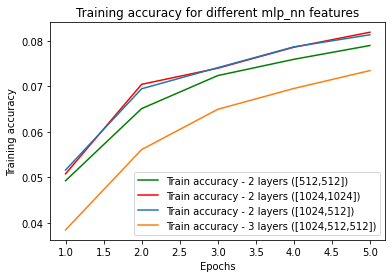

In [ ]:
#plotting training accuracy for different MLP models
plt.title('Training accuracy for different MLP features')
plt.plot([i+1 for i in range(5)], train_accuracies_512,'-g')
plt.plot([i+1 for i in range(5)], train_accuracies_1024,'-r')
plt.plot([i+1 for i in range(5)], train_accuracies_1024_2) 
plt.plot([i+1 for i in range(5)], train_accuracies_512_2)
plt.xlabel('Epochs')
plt.ylabel('Training accuracy')                                                 
plt.legend(['Train accuracy - 2 layers ([512,512])', 'Train accuracy - 2 layers ([1024,1024])', 'Train accuracy - 2 layers ([1024,512])', 'Train accuracy - 3 layers ([1024,512,512])'])
plt.show()

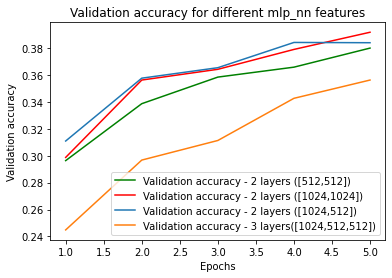

In [ ]:
#plotting validation accuracy for different MLP models
plt.title('Validation accuracy for different MLP features')                   
plt.plot([i+1 for i in range(5)], val_accuracies_512,'-g')                      
plt.plot([i+1 for i in range(5)], val_accuracies_1024,'-r')                     
plt.plot([i+1 for i in range(5)], val_accuracies_1024_2)                        
plt.plot([i+1 for i in range(5)], val_accuracies_512_2)                          
plt.xlabel('Epochs')                                                            
plt.ylabel('Validation accuracy')                                               
plt.legend(['Validation accuracy - 2 layers ([512,512])', 'Validation accuracy - 2 layers ([1024,1024])', 'Validation accuracy - 2 layers ([1024,512])', 'Validation accuracy - 3 layers([1024,512,512])'])
plt.show()                                                                                        

## RUNNING OUR TWO CNN MODELS

In [ ]:
#calling our first CNN network with conv layers of 64 filters and two dense layers with 512 nodes
model = CNN1()
model = model.to(device)                                                                              
learning_rate = 1e-4 #setting the learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #using the adam optimizer 
loss_func = nn.CrossEntropyLoss() #using cross entropy loss as our loss function

#training the model and returning training, validation loss and accuracies for each epoch
train_losses_cnn1, train_accuracies_cnn1,  val_losses_cnn1, val_accuracies_cnn1 = train(model, optimizer, loss_func, traindata_loader, valdata_loader)

#calling the predict function to return the model's test loss and accuracy
predict(model, loss_func, test_loader)

Train Epoch: 1, Train Loss: 621.818322, Train Accuracy: 0.059520
Val Epoch:   1, Val Loss: 283.647261, Val Accuracy: 0.372000
Train Epoch: 2, Train Loss: 520.060606, Train Accuracy: 0.083600
Val Epoch:   2, Val Loss: 245.040213, Val Accuracy: 0.440600
Train Epoch: 3, Train Loss: 462.824163, Train Accuracy: 0.095220
Val Epoch:   3, Val Loss: 229.033404, Val Accuracy: 0.476000
Train Epoch: 4, Train Loss: 420.328333, Train Accuracy: 0.104520
Val Epoch:   4, Val Loss: 223.058940, Val Accuracy: 0.483800
Train Epoch: 5, Train Loss: 382.822867, Train Accuracy: 0.113660
Val Epoch:   5, Val Loss: 207.170175, Val Accuracy: 0.526400
Test Loss: 208.918564, Test Accuracy: 0.520000


In [ ]:
#calling our second CNN network with conv layers of 64 filters and two dense layers with 512 nodes
model = CNN2()
model = model.to(device)                                                        
learning_rate = 1e-4 #setting the learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #using the adam optimizer 
loss_func = nn.CrossEntropyLoss() #using cross entropy loss as our loss function

#training the model and returning training, validation loss and accuracies for each epoch
train_losses_cnn2, train_accuracies_cnn2,  val_losses_cnn2, val_accuracies_cnn2 = train(model, optimizer, loss_func, traindata_loader, valdata_loader)

#calling the predict function to return the model's test loss and accuracy
predict(model, loss_func, test_loader)

Train Epoch: 1, Train Loss: 664.728028, Train Accuracy: 0.043780
Val Epoch:   1, Val Loss: 308.259265, Val Accuracy: 0.290800
Train Epoch: 2, Train Loss: 587.418724, Train Accuracy: 0.064740
Val Epoch:   2, Val Loss: 284.513886, Val Accuracy: 0.354800
Train Epoch: 3, Train Loss: 547.941668, Train Accuracy: 0.074900
Val Epoch:   3, Val Loss: 267.274221, Val Accuracy: 0.393800
Train Epoch: 4, Train Loss: 514.865102, Train Accuracy: 0.082040
Val Epoch:   4, Val Loss: 252.280985, Val Accuracy: 0.409400
Train Epoch: 5, Train Loss: 486.372839, Train Accuracy: 0.087960
Val Epoch:   5, Val Loss: 240.595774, Val Accuracy: 0.450800
Test Loss: 239.688155, Test Accuracy: 0.449400


## PLOTTING TRAINING AND VALIDATION CURVES FOR OUR CNN MODELS

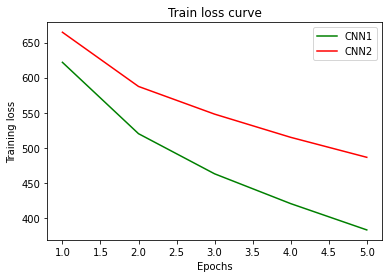

In [ ]:
#plotting the train loss curve for our 2 CNN networks
plt.title('Train loss curve')
plt.plot([i+1 for i in range(5)], train_losses_cnn1,'g-')
plt.plot([i+1 for i in range(5)], train_losses_cnn2,'r-')
plt.xlabel('Epochs')                                    
plt.ylabel('Training loss')
plt.legend(['CNN1', 'CNN2'])
plt.show()

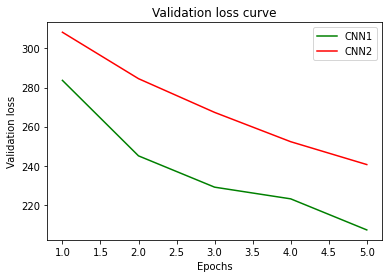

In [ ]:
#plotting the validation loss curve for our 2 CNN networks
plt.title('Validation loss curve')
plt.plot([i+1 for i in range(5)], val_losses_cnn1,'g-')
plt.plot([i+1 for i in range(5)], val_losses_cnn2,'r-')
plt.xlabel('Epochs')                                   
plt.ylabel('Validation loss')
plt.legend(['CNN1', 'CNN2'])
plt.show()